In [1]:
import sys
import yaml
import os
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import cv2
import torch
sys.path.append(os.path.abspath(".."))

In [2]:
# Импортируем функцию для определения корня проекта
sys.path.append(os.path.abspath("../scripts"))
from utils import get_project_root

# Добавляем корень проекта в sys.path
sys.path.append(get_project_root())

from scripts.utils import get_project_paths
from scripts.utils import plot_training_results
from scripts.utils import show_feature_top_images, show_random_fc_activations, show_activation_maps, grad_cam, show_grad_cam_results

In [3]:
project_root = get_project_root()
params_path = os.path.join(project_root, "params.yaml")

with open(params_path, "r") as f:
    params = yaml.safe_load(f)
    paths = get_project_paths()

# Наша модель для обучения

class MyCNN(nn.Module):
    def __init__(self, activation='relu', dropout=None, spatial_drop=0.2):
        super().__init__()

        # --- активация ---
        act = activation.lower()
        if   act == "relu":      self.activation = nn.ReLU()
        elif act == "tanh":      self.activation = nn.Tanh()
        elif act == "sigmoid":   self.activation = nn.Sigmoid()
        elif act == "leaky_relu":self.activation = nn.LeakyReLU()
        elif act == "elu":       self.activation = nn.ELU()
        elif act == "swish":     self.activation = Swish()
        elif act == "mish":      self.activation = Mish()
        else: raise ValueError(f"Unknown activation: {activation}")

        # --- dropout'ы ---
        self.use_dropout = dropout is not None and dropout > 0
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout)

        # Spatial-dropout-2D по каналам
        self.use_spatial = spatial_drop is not None and spatial_drop > 0
        if self.use_spatial:
            self.spatial_dropout = nn.Dropout2d(spatial_drop)

        # --- сверточные блоки ---
        self.conv1 = nn.Conv2d(3,  8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # 224 → 112 → 56 → 28
        self.fc  = nn.Linear(28*28*64, 1000)
        self.out = nn.Linear(1000, 1)     # бинарный логит

    def forward(self, x):
        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))

        # Spatial-Dropout на уровне каналов
        if self.use_spatial and self.training:
            x = self.spatial_dropout(x)

        x = self.pool3(self.activation(self.conv3(x)))

        # обычный dropout на FC-части 
        x = torch.flatten(x, 1)
        x = self.fc(x)
        if self.use_dropout and self.training:
            x = self.dropout(x)

        features = x
        logits   = self.out(features)   # BCEWithLogitsLoss ждёт «сырые» логиты
        return logits, features

# Попробуем прогнать ее через optuna


=== Activation: ELU ===



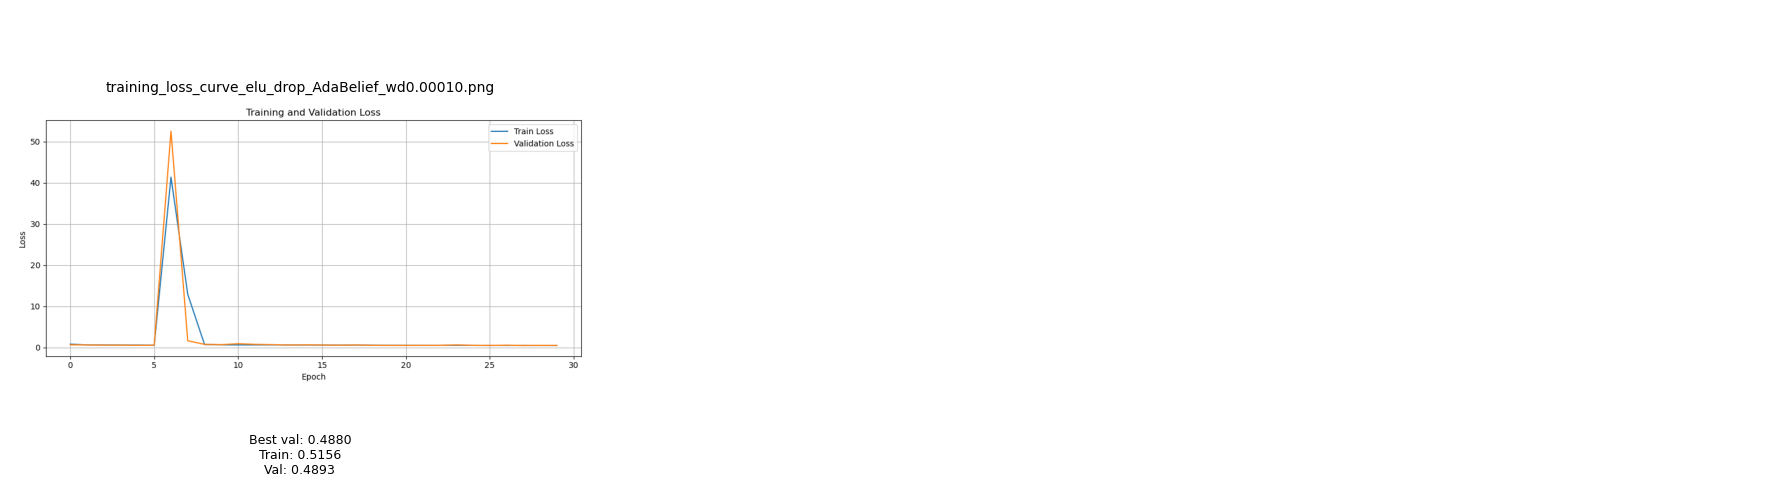


=== Activation: SWISH ===



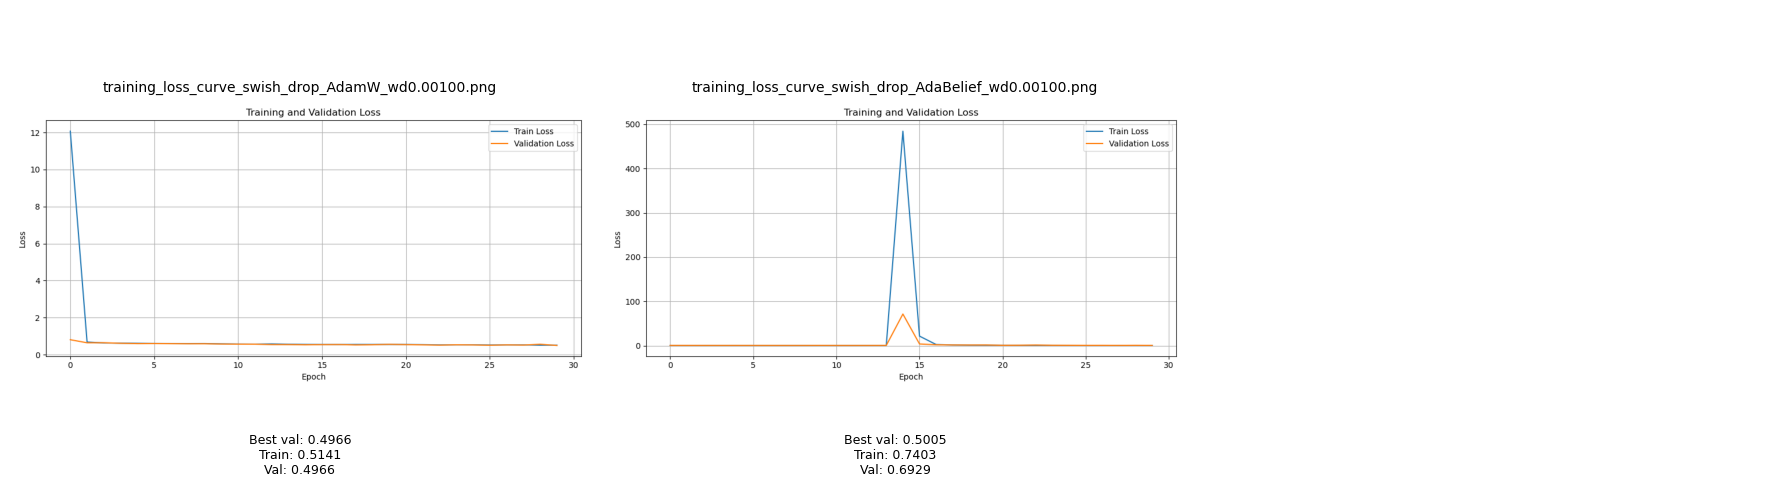


=== Activation: TANH ===



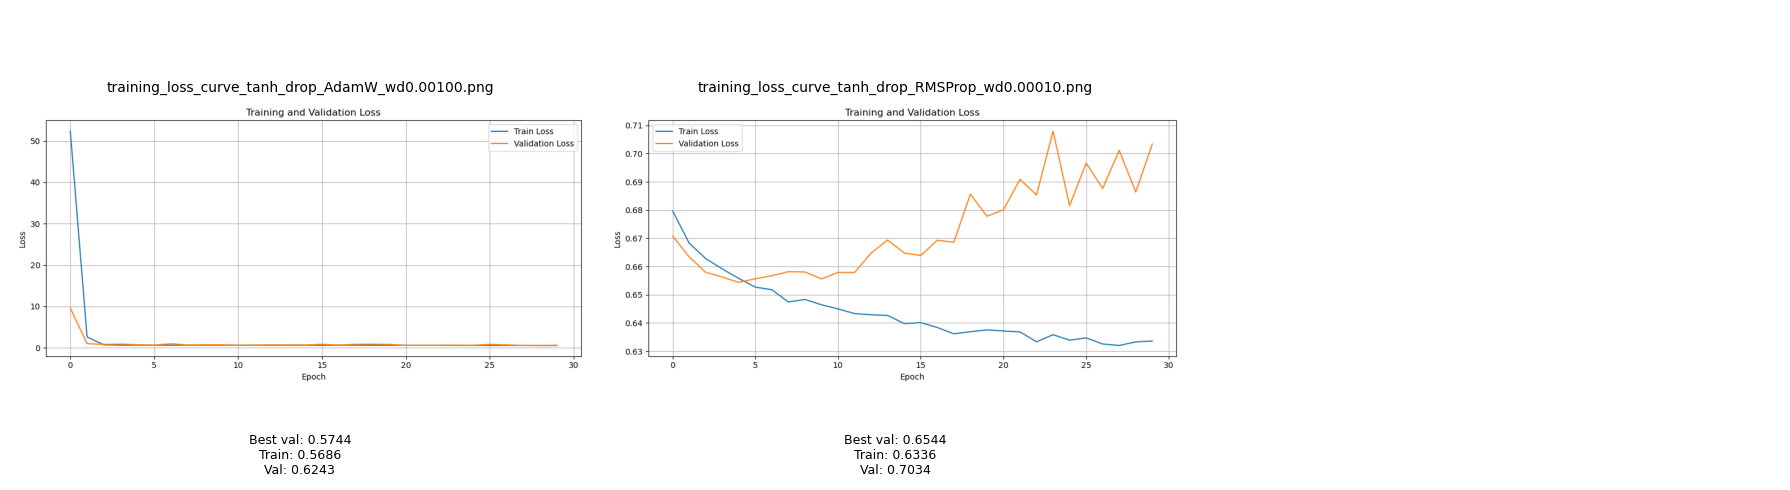


=== Activation: MISH ===



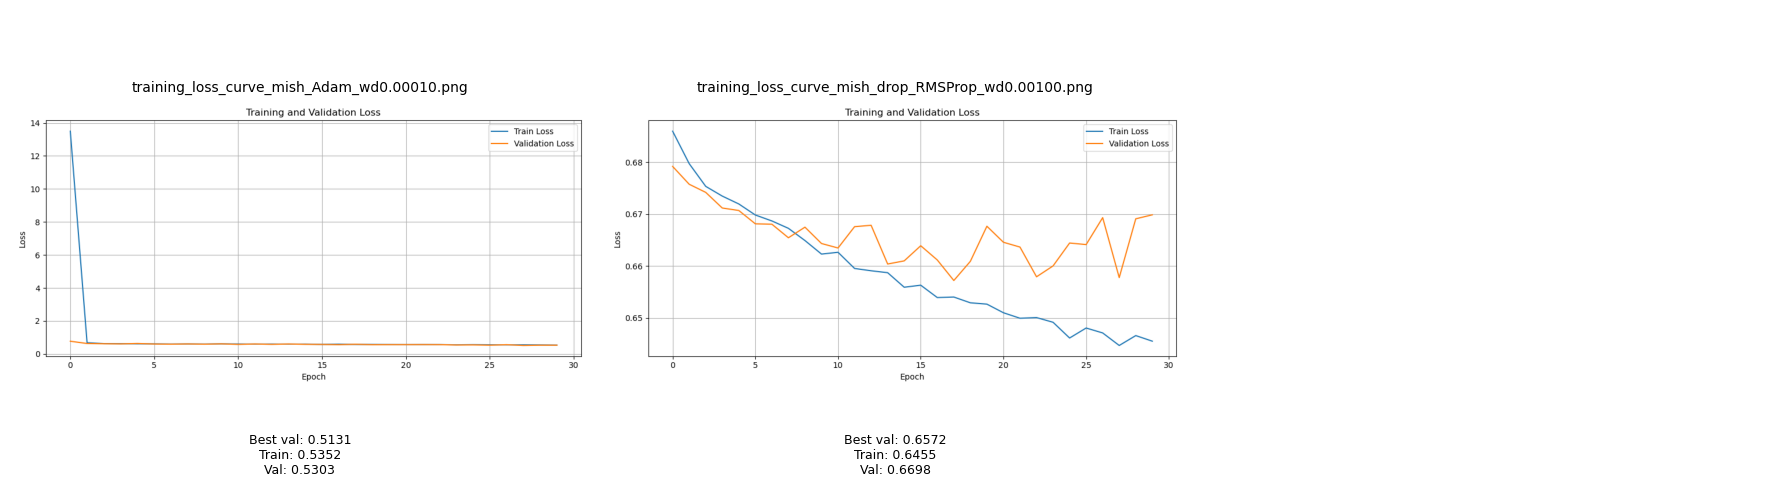


=== Activation: RELU ===



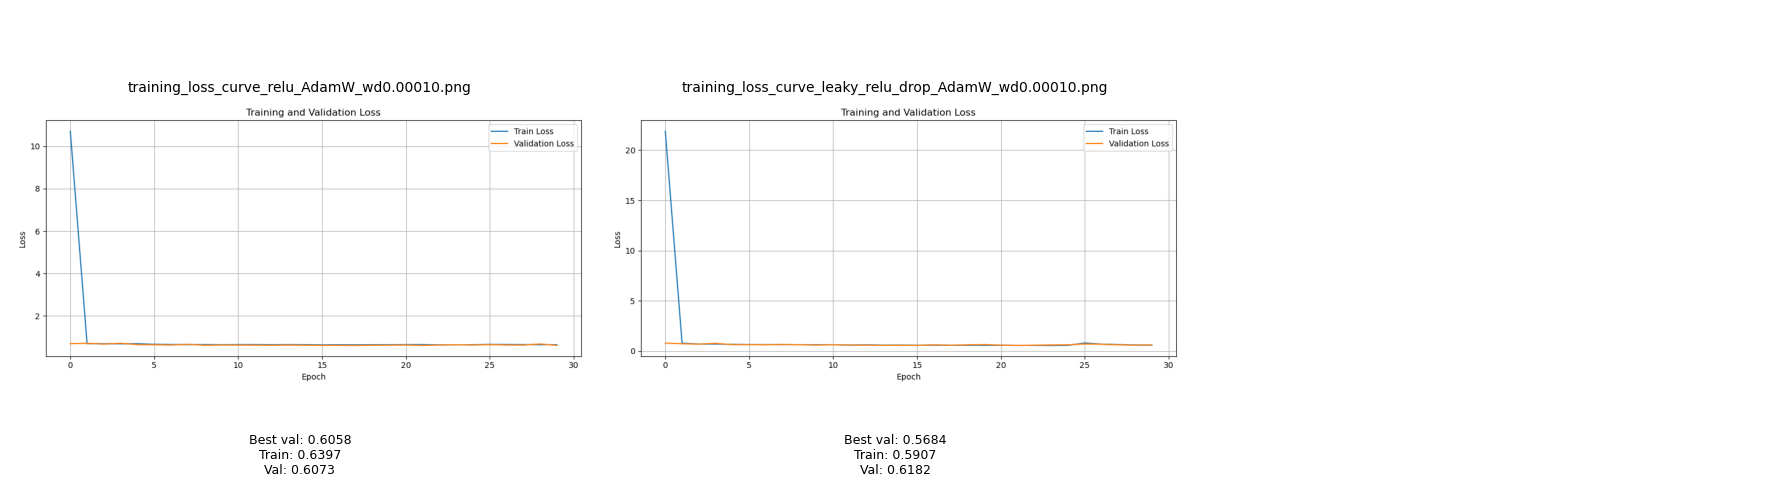


=== Activation: SIGMOID ===



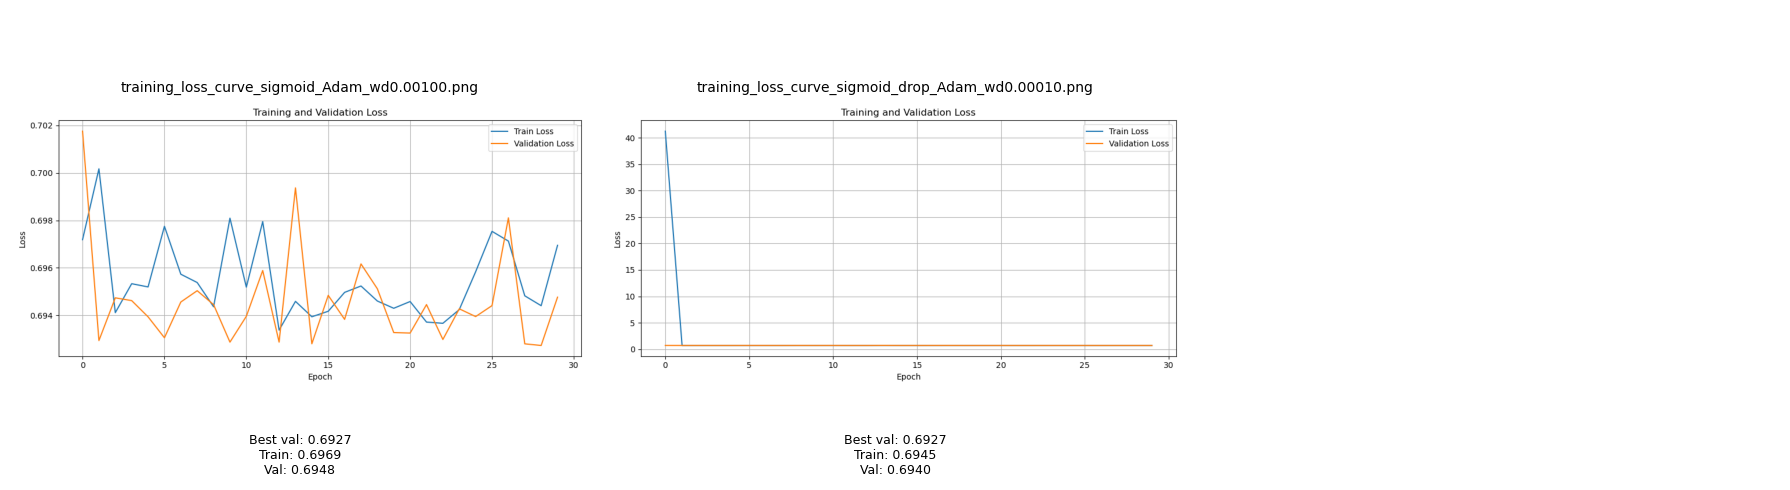


=== Activation: UNKNOWN ===



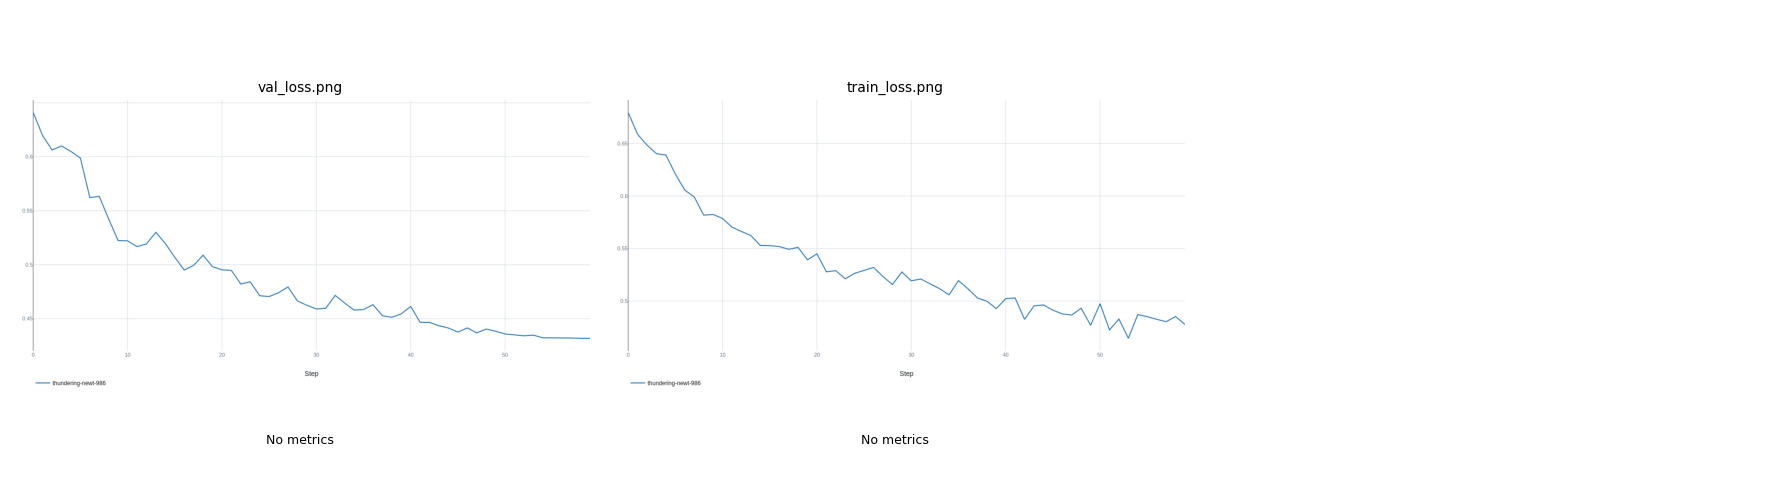

In [4]:
plot_training_results()

## Из получившихся моделей лучшими будут:
tanh_drop_AdamW_wd0.00100   и mish_Adam_wd0.00010
Попробуем предиктить на них

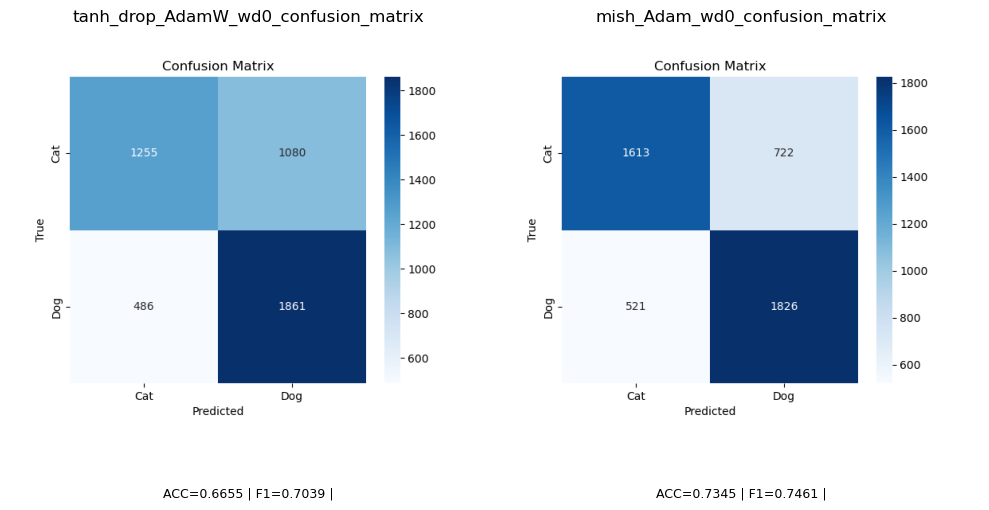

In [5]:
img1 = Image.open(paths['image_dir']/"tanh_drop_AdamW_wd0_confusion_matrix.png") 
img2 = Image.open(paths['image_dir']/"mish_Adam_wd0_confusion_matrix.png") 

y1 = np.load(paths['vectors_dir']/"labels_tanh_drop_AdamW_wd0.npy")
stack_pred1 = np.load(paths['vectors_dir']/"pred_tanh_drop_AdamW_wd0.npy")

y2 = np.load(paths['vectors_dir']/"labels_mish_Adam_wd0.npy")
stack_pred2 = np.load(paths['vectors_dir']/"pred_mish_Adam_wd0.npy")

acc1 = accuracy_score(y1, stack_pred1)
f11 = f1_score(y1, stack_pred1)
acc2 = accuracy_score(y2, stack_pred2)
f12 = f1_score(y2, stack_pred2)


info = f" ACC={acc1:.4f} | F1={f11:.4f} | "
info2 = f" ACC={acc2:.4f} | F1={f12:.4f} | "

# Создаем фигуру с 1 строкой и 2 столбцами
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # (рядов, колонок)

# Отображаем tanh_drop_AdamW_wd0_confusion_matrix.png
axs[0].imshow(img1)
axs[0].axis('off')
axs[0].set_title("tanh_drop_AdamW_wd0_confusion_matrix")
axs[0].text(0.5, -0.15, info, ha="center", va="top", fontsize=9, transform=axs[0].transAxes)

# Отображаем второе изображение
axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title("mish_Adam_wd0_confusion_matrix")
axs[1].text(0.5, -0.15, info2, ha="center", va="top", fontsize=9, transform=axs[1].transAxes)

# Показываем все вместе
plt.tight_layout()
plt.show()

### Визуально матрица ошибок у модели на Mish лучше. Метрики так же лучше. Но всеже 73% точности не оченьдостаточно поробуем улучшитьмодель ненмого изменив обучение:


Balanced Sampler WeightedRandomSampler	- Вычисляем частоту классов.
- Каждому образцу назначаем вес wᵢ = 1 / freq(labelᵢ).
- Sampler вытягивает элементы с вероятностью ∝ wᵢ, так что в каждом эпоховом потоке классы появляются ≈ поровну.	• Убирает «смещение» градиента, если классы не 50/50.
- Эквивалент «костыльной» балансировки pos_weight, но уже на уровне данных – это лучше согласуется с BatchNorm и MixUp.

RandAugment	- Список из ≈ 15 аугментаций (Rotate, Sharpness, Color, Solarize, …).
- Каждый раз случайно берутся N операций (обычно N=2) с общей «силой» M (0–30).
- Не нужно искать комбинации (в отличие от AutoAugment).	• Расширяет разнообразие фона/цветов → учит не прикипать к артефактам.
• Пара (N, M) = (2, 9) стабильно даёт +2-3 pp на задачах pets, flowers, cats-vs-dogs.

One-Cycle LR	
- LR ↑ от lr_base до lr_max (~ ×10) за первые 30 % эпох → мощный «разогрев» (эпохи 0–18).
- LR ↓ до очень малого (1e-6) за оставшиеся эпохи → «тонкая полировка».
- В PyTorch делается OneCycleLR(optimizer, max_lr, epochs, steps_per_epoch).	• Высокий LR в начале выталкивает из локальных минимумов, даёт лучшее «покрытие» и приближает к широким минимумам.
• Фаза спуска резко снижает обучающую ошибку, уменьшая over-fitting.

MixUp	Для пары картинок (x₁,y₁) и (x₂,y₂):
λ ~ Beta(α,α) →
x̃ = λ·x₁ + (1-λ)·x₂
ỹ = λ·y₁ + (1-λ)·y₂ (для BCE — просто 0/1 вектор).	• «Размывает» границу решений, заставляя выход ближе к вероятностям.
• Учит модель фокусироваться не на уникальных деталях одной картинки, а на более общих признаках → регуляризация ~ как Dropout + аугментации вместе.

Label Smoothing + pos_weight	• Смягчаем таргет: 1 → 0.95, 0 → 0.05 (smoothing 0.05).
• pos_weight = (#neg / #pos) в BCEWithLogits цитирует неправдоподобно лёгкие «кошки».	• Снижаем «самоуверенные» выходы → меньше взрывных градиентов.
• pos_weight заставляет модель доплачивать за пропущенных кошек (False Negatives).

EMA (Exponential Moving Average)	Каждую итерацию: θ̄ ← β·θ̄ + (1-β)·θ (β≈0.999).
- θ — текущие веса после optimizer.step().
- На валидации/инференсе берём θ̄.	• Фактически маленький «ансамбль» всех последних шагов.
• Сглаживает шум SGD → повышает стабильность, уменьшает переобучение на последние батчи.

SWA (Stochastic Weight Averaging)	- Раз в эпоху после swa_start собираем копию весов в swa_model.update_parameters(model).
- В конце обновляем BN-статистики: update_bn(loader, swa_model).	• Среднее по «хорошим» точкам траектории попадает в широкий (плоский) минимум → лучше обобщается.
• Часто +1-3 pp к F1 без ухудшения скорости.

### В результате была получена следующая модель

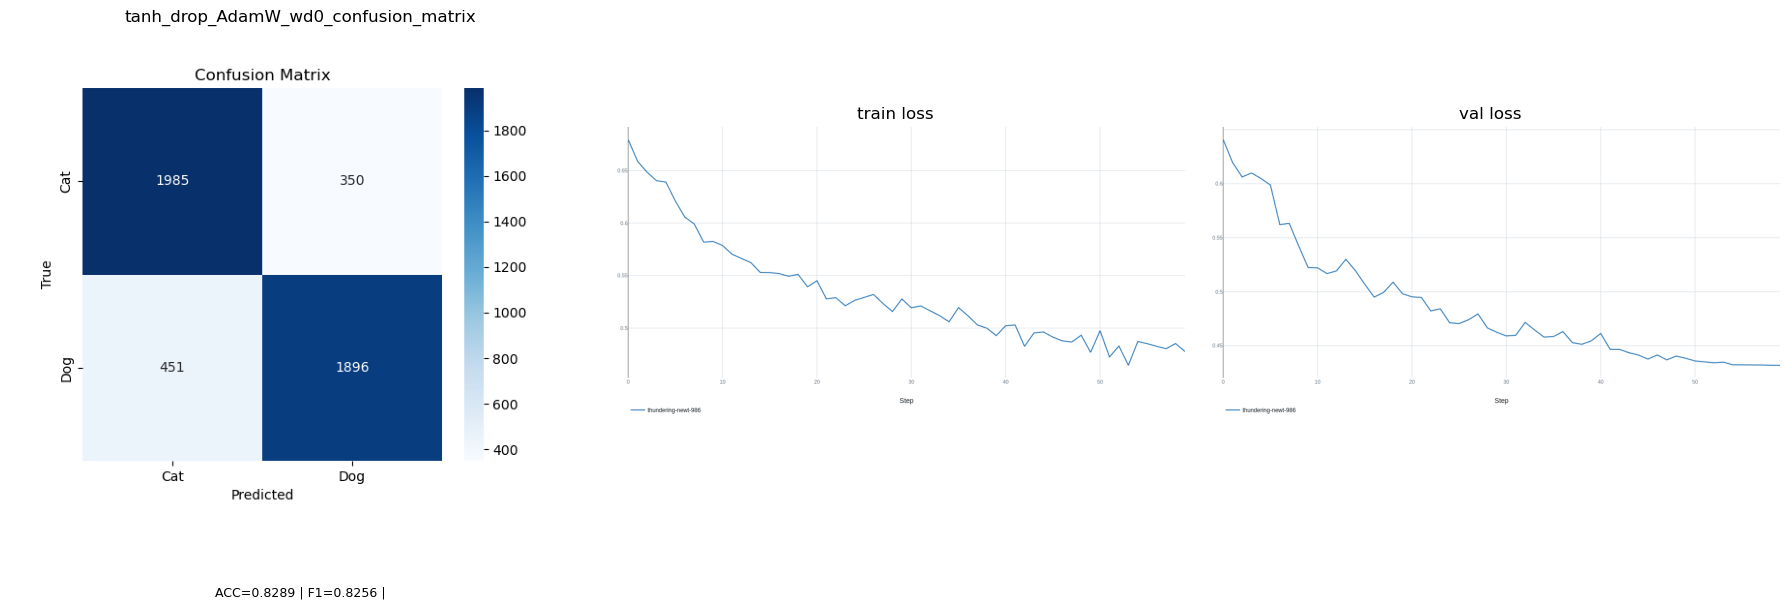

In [6]:
img1 = Image.open(paths['image_dir']/"mish_best_final_model_v2_confusion_matrix.png") 
img2 = Image.open(paths['image_dir']/"train_loss.png") 
img3 = Image.open(paths['image_dir']/"val_loss.png") 

y1 = np.load(paths['vectors_dir']/"labels_mish_best_final_model_v2.npy")
stack_pred1 = np.load(paths['vectors_dir']/"pred_mish_best_final_model_v2.npy")


acc1 = accuracy_score(y1, stack_pred1)
f11 = f1_score(y1, stack_pred1)

info = f" ACC={acc1:.4f} | F1={f11:.4f} | "

# Создаем фигуру с 1 строкой и 2 столбцами
fig, axs = plt.subplots(1, 3, figsize=(18, 8))  # (рядов, колонок)

# Отображаем tanh_drop_AdamW_wd0_confusion_matrix.png
axs[0].imshow(img1)
axs[0].axis('off')
axs[0].set_title("tanh_drop_AdamW_wd0_confusion_matrix")
axs[0].text(0.5, -0.15, info, ha="center", va="top", fontsize=9, transform=axs[0].transAxes)

# Отображаем второе изображение
axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title("train loss")

# Отображаем второе изображение
axs[2].imshow(img3)
axs[2].axis('off')
axs[2].set_title("val loss")


# Показываем все вместе
plt.tight_layout()
plt.show()

### И матрица ошибок и метрики лучше чем у предуюущих моделей

Loaded 4682 samples with 1000 features.


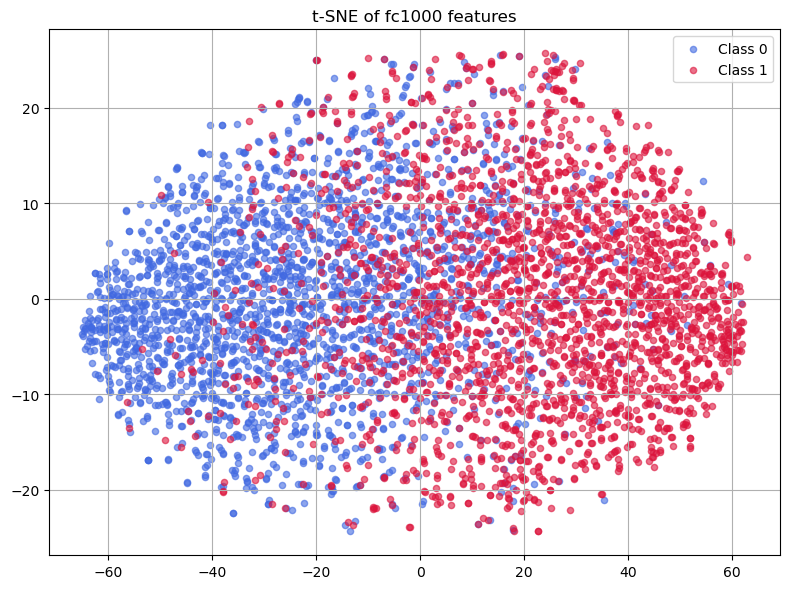

In [7]:
# === Загрузка ===
fc_path = paths['vectors_dir']/"test_fc1000_mish_best_final_model_v2.npy"
labels_path = paths['vectors_dir']/"test_labels_mish_best_final_model_v2.npy"

X = np.load(fc_path)       # (N, 1000)
y = np.load(labels_path)   # (N,)

print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features.")

# === Стандартизация (важно для t-SNE) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === t-SNE ===
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# === Визуализация ===
plt.figure(figsize=(8, 6))
colors = ['royalblue', 'crimson']
for label in np.unique(y):
    idx = y == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], 
                label=f"Class {label}", 
                alpha=0.6, s=20, c=colors[label])

plt.title("t-SNE of fc1000 features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

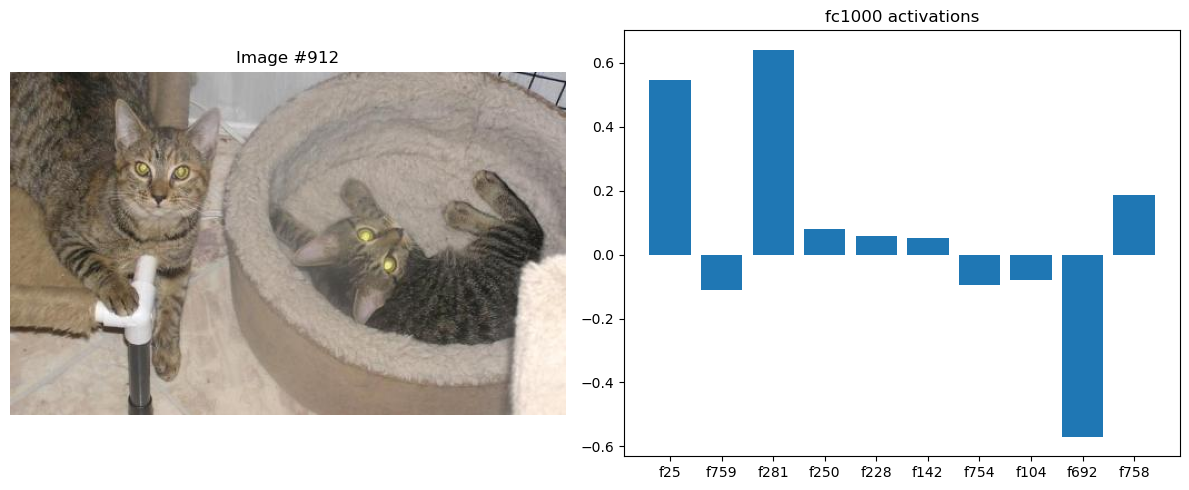

In [8]:
show_random_fc_activations(
    fc_path      = paths["vectors_dir"] / "test_fc1000_mish_best_final_model_v2.npy",
    parquet_path = paths["raw_dir"] / "test.parquet",
    # neuron_indices=[1, 10, 20, 14],   # можно задать вручную
    random_state = 42
)

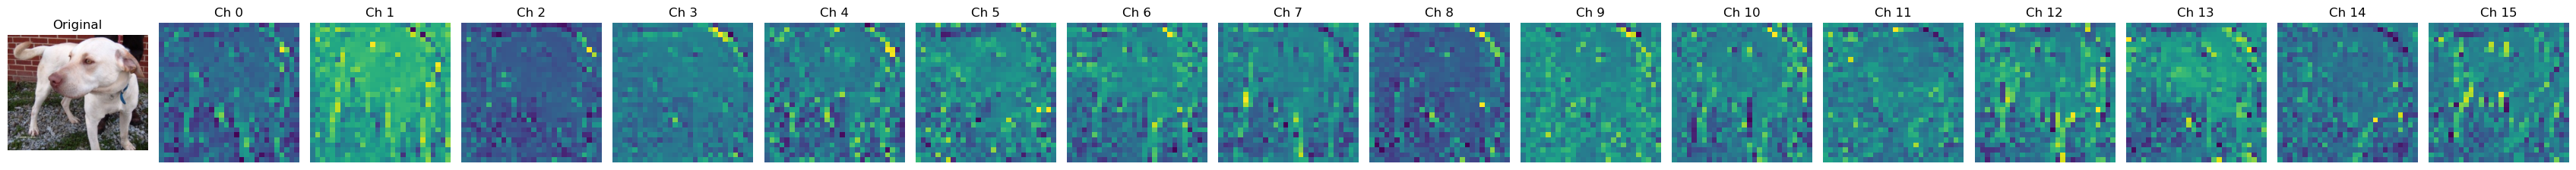

In [9]:
example = np.load(paths["vectors_dir"] /"conv3_out/img00012_conv3.npy")  # (C, H, W)
show_activation_maps(torch.tensor(example),idx=12)

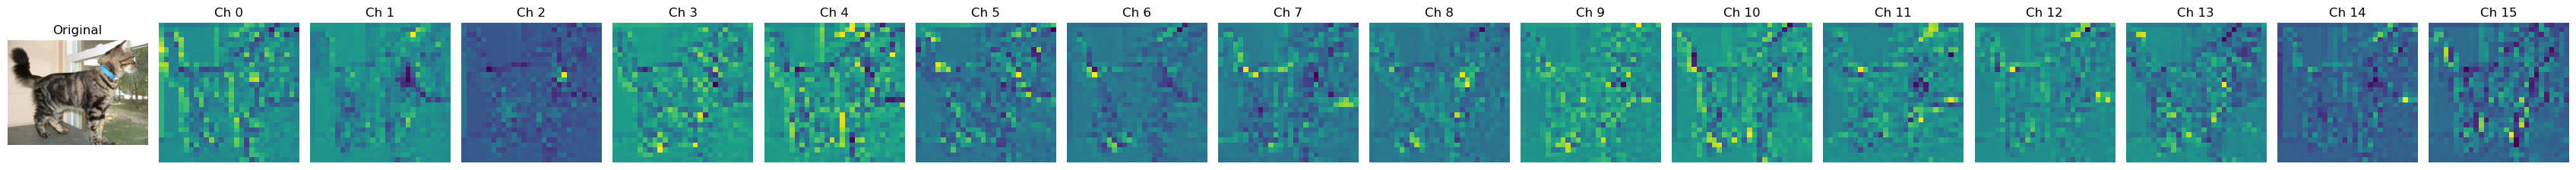

In [10]:
example = np.load(paths["vectors_dir"] /"conv3_out/img00056_conv3.npy")  # (C, H, W)
show_activation_maps(torch.tensor(example),idx=56)

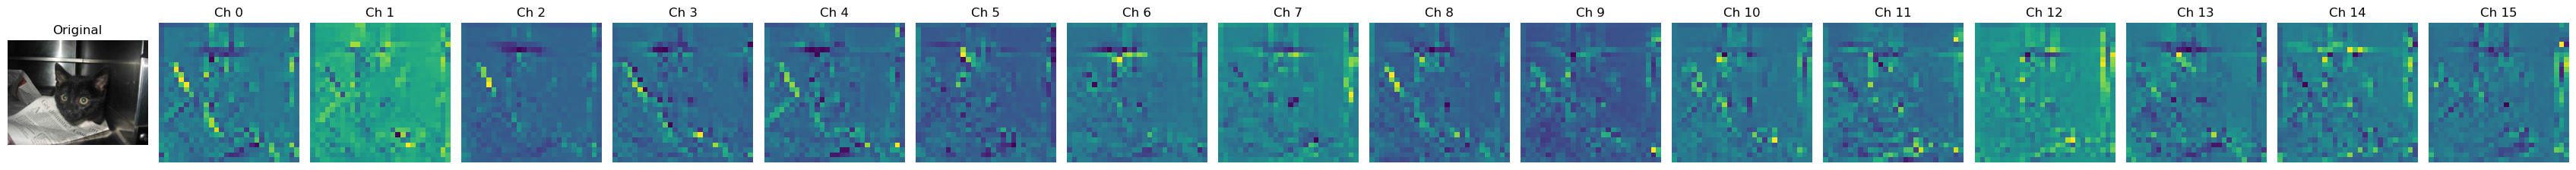

In [11]:
example = np.load(paths["vectors_dir"] /"conv3_out/img00033_conv3.npy")  # (C, H, W)
show_activation_maps(torch.tensor(example),idx=33)

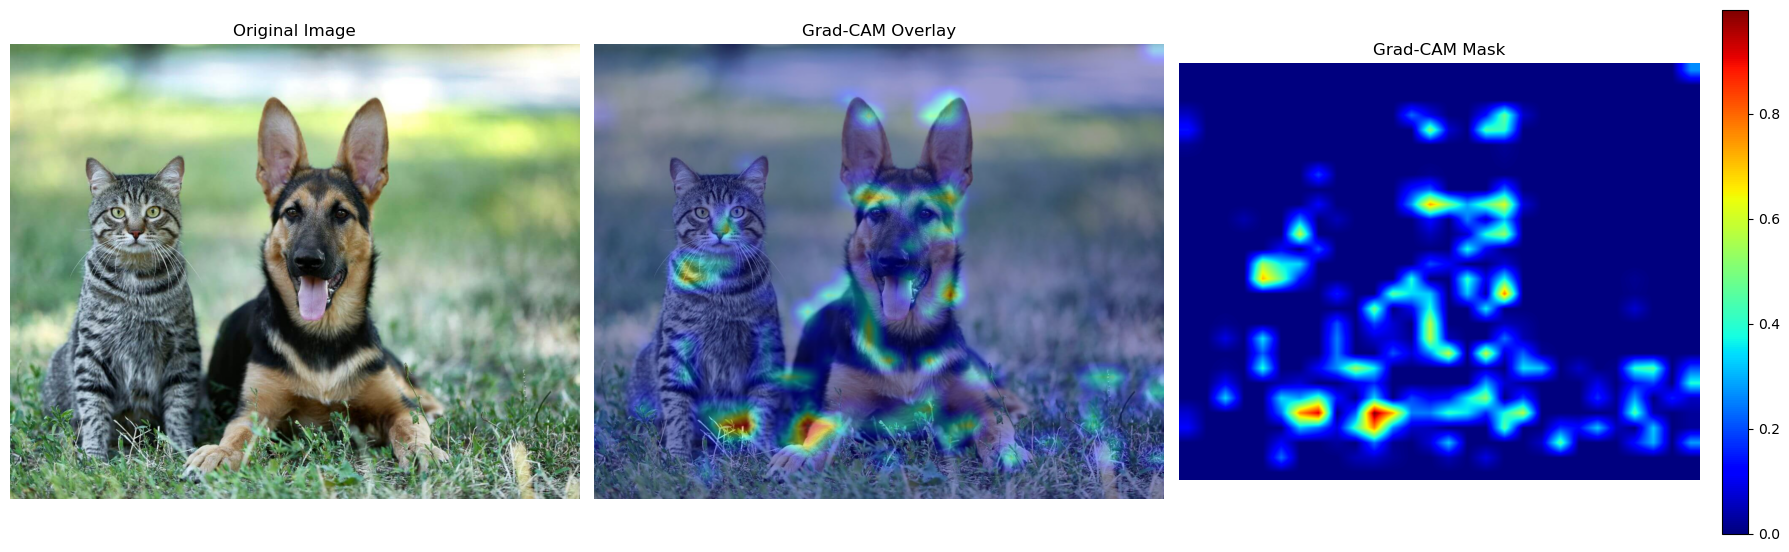

In [12]:
img_bgr = cv2.imread(str(paths['image_dir']/"blog-cane-e-gatto.jpg"))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

class_idx, score, cam_overlayed, cam_mask = grad_cam(img_bgr)

show_grad_cam_results(img_rgb, cam_overlayed, cam_mask)